### 0. 패키지 로딩하기

In [1]:
from tensorflow import keras

import urllib3
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

urllib3.disable_warnings()

In [2]:
# GPU 확인하기
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1. 데이터 불러오기

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split         = ["train", "test"],
    shuffle_files = True,
    with_info     = True
)

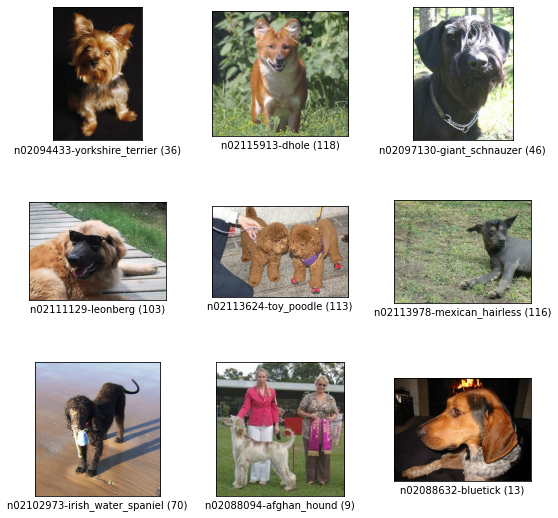

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

### 2. Augmentation 적용하기

#### 2_1. 텐서플로우 Random Augmentation API 사용하기

* Augmentation을 적용하기에 앞서 기본적인 전처리 함수를 만든다.

In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images : "uint8" -> "float32"."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

* random augmentation들 중에서 random_flip_left_right()과 random_brightness()를 활용한다.
* "flip"의 경우 좌우 대칭을 해준다.
* 예를들어 이미지 분류 문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않는다. 따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있디. 여기서 상하대칭은 테스트 데이터셋의 이미지를 생각해볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않는다.
* 또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 한다.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta = 0.2)
    return image,label

* 오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의하겠다.
* 여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠다.
* 이때 주의해야할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점이다.
* 참고로, 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠다.

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls = 2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls = 2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2_2. Random Augmentation 직접 구현하기

* 위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했다.
* 이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성한다.

In [8]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00)) # 50%의 확률로 이미지 가운데 부분을 crop한다.
    image = tf.image.resize(image, INPUT_SHAPE) # crop한 이미지를 원본 사이즈로 resize
    return image, label

### 3. 비교실험 하기

* 이제 비교실험을 해보도록 하겠다.
* 우리가 비교해야 하는 것은 augmentation을 적용한 데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능이다.
* 새로운 augmentation이 생각났다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있다.
* 아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet에 훈련된 모델을 불러온다.
* include_top은 마지막 fully connected layer를 포함할지 여부이다.
* 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다.
* 이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문이다.

In [9]:
num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

* Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어준다.

In [15]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

* 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 한다.

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split         = ["train", "test"],
    as_supervised = True,
    shuffle_files = True,
    with_info     = True
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug = False)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug = True)
ds_test         = apply_normalize_on_dataset(ds_test, is_test   = True)

* 이제 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행한다.

In [17]:
# 아래 학습은 EPOCH = 20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요된다.
# Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 한다.
# 원활한 학습 진행을 위해서는 EPOCH = 3 정도로 진행해 보기를 권한다.
# 하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 한다.

EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2020)

resnet50.compile(
    loss      = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

aug_resnet50.compile(
    loss      = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

Epoch 1/20
750/750 [==============================] - 109s 146ms/step - loss: 2.2249 - accuracy: 0.4385 - val_loss: 3.4538 - val_accuracy: 0.2002
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.7826 - accuracy: 0.7800 - val_loss: 1.1264 - val_accuracy: 0.6670
Epoch 3/20
750/750 [==============================] - 112s 149ms/step - loss: 0.2972 - accuracy: 0.9293 - val_loss: 0.9616 - val_accuracy: 0.7176
Epoch 4/20
750/750 [==============================] - 112s 149ms/step - loss: 0.0894 - accuracy: 0.9892 - val_loss: 0.9322 - val_accuracy: 0.7343
Epoch 5/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0529 - accuracy: 0.9970 - val_loss: 0.9373 - val_accuracy: 0.7388
Epoch 6/20
750/750 [==============================] - 112s 149ms/step - loss: 0.0282 - accuracy: 0.9987 - val_loss: 0.9496 - val_accuracy: 0.7390
Epoch 7/20
750/750 [==============================] - 113s 150ms/step - loss: 0.0125 - accuracy: 0.9992 - val_loss: 0.9396 -

750/750 [==============================] - 111s 148ms/step - loss: 2.2586 - accuracy: 0.4338 - val_loss: 2.9664 - val_accuracy: 0.2681
Epoch 2/20
750/750 [==============================] - 112s 149ms/step - loss: 0.9478 - accuracy: 0.7269 - val_loss: 1.1431 - val_accuracy: 0.6638
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 0.5202 - accuracy: 0.8572 - val_loss: 1.3647 - val_accuracy: 0.6206
Epoch 4/20
750/750 [==============================] - 112s 150ms/step - loss: 0.3027 - accuracy: 0.9240 - val_loss: 1.1632 - val_accuracy: 0.6702
Epoch 5/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1558 - accuracy: 0.9682 - val_loss: 0.9402 - val_accuracy: 0.7308
Epoch 6/20
750/750 [==============================] - 112s 150ms/step - loss: 0.1019 - accuracy: 0.9816 - val_loss: 0.9820 - val_accuracy: 0.7248
Epoch 7/20
750/750 [==============================] - 112s 150ms/step - loss: 0.0587 - accuracy: 0.9915 - val_loss: 0.9586 - val_accura

* 훈련 과정을 시각화

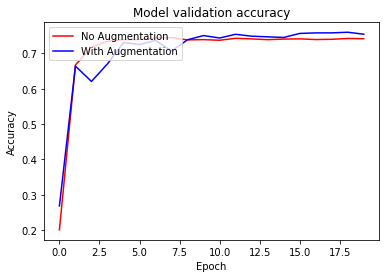

In [18]:
plt.plot(history_resnet50_no_aug.history["val_accuracy"], "r")
plt.plot(history_resnet50_aug.history["val_accuracy"],    "b")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["No Augmentation", "With Augmentation"], loc = "upper left")
plt.show()

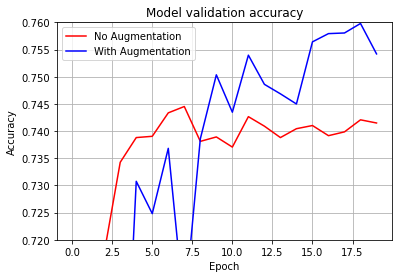

In [19]:
# 조금 더 확대했다.
plt.plot(history_resnet50_no_aug.history["val_accuracy"], "r")
plt.plot(history_resnet50_aug.history["val_accuracy"],    "b")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["No Augmentation", "With Augmentation"], loc = "upper left")
plt.grid(True)
plt.ylim(0.72, 0.76)    # 출력하고자 하는  Accuracy 범위를 지정한다. EPOCH = 20으로 진행시 적절한 범위는 옆에 나온 숫자이다.  
plt.show()

### 4. Cutmix Augmentation

* 지금부터 조금 더 복잡한 augmentation 방법을 알아본다.
* 첫 번째는 CutMix augmentation이다.
* CutMix는 네이버 클로바(CLOVA)에서 발표한 CutMix : Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법이다.
* 이름인 CutMix를 보고 유추할 수 있듯 이미지 데이터를 자르고 섞는다고 생각할 수 있다.

* https://arxiv.org/pdf/1905.04899.pdf
* 위 링크에서 바로 보이는 표에서 ResNet-50 컬럼은 우리가 일반적으로 사용해왔던 방식을 나타낸다.
* Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식이다.
* CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법이다. 차에 비유하면 블렌딩 같은 방법이라 볼 수 있다.
* https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu
* 두 번째 링크인 Chris Deotte's CutMix and MixUp on GPU/TPU에서는 캐글 그랜드마스터인 Chris Deotte가 구현한 CutMix와 MixUp을 확인 할 수 있다.
* 남은 스텝에서 CutMix와 MixUp을 구현하면서 참고하도록 하자. 
* 참고로 캐글에서 지금 참가하고 있는 대회와 비슷한 태스크의 경진대회가 있는 경우, 다른 사람들이 적용한 방법들을 찾아보는 것도 인사이트를 얻는 데 좋다.
* CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함한다. 이제 한 부분씩 구현해 본다.

#### 4_1. 이미지 섞기

* 가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해보자.
* 배치 내의 이미지를 두 개 골라서 섞어준다.
* 이때 이미지에서 잘라서 섞어주는 영역을 바운딩 박스(bounding box)라고 부른다.
* 예시를 위해 훈련데이터셋에서 이미지 2개를 가져와 확인해보자.
* 아래 코드블록에 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만들자.
* 이미지를 텐서로 만들어 텐서플로우 연산을 사용해보자. 이때 이미지는 tfds에서 한 장을 뽑아서 사용해 보자.

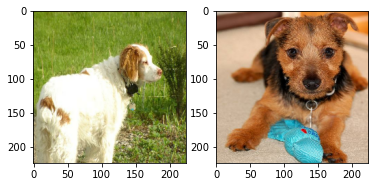

In [11]:
# 데이터셋에서 이미지 2개를 가져오기. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

* 방금 두 개의 이미지를 얻었다.
* 이 중 첫번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현해 보자.
* 이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, CutMix 공식 레포에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현하자.

In [12]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width  = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x - width //  2)
    ya = tf.math.maximum(0, y - height // 2)
    xb = tf.math.minimum(image_size_x, x + width // 2)
    yb = tf.math.minimum(image_size_y, y + width // 2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(112, shape=(), dtype=int32) tf.Tensor(120, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


* 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현한다.

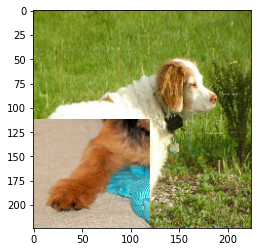

In [13]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one          = image_a[ya : yb, 0  : xa, :]
    two          = image_b[ya : yb, xa : xb, :]
    three        = image_a[ya : yb, xb : image_size_x, :]
    middle       = tf.concat([one, two, three], axis = 1)
    top          = image_a[0 : ya, :, :]
    bottom       = image_a[yb : image_size_y, :, :]
    mixed_img    = tf.concat([top, middle, bottom], axis = 0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

#### 4_2. 라벨 섞기

* 이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 한다.
* 그림에서 볼 수 있듯, 우리가 강아지와 고양이의 이미지를 섞었다면 라벨 또한 적절한 비율로 섞여야 한다.
* CutMix에서는 면적에 비례해서 라벨을 섞어준다.
* 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해준다.
* 예를 들어 A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해준다. 이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용한다.
* 위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현하자.

In [14]:
# mix two labels
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes = 120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area   = (xb - xa) * (yb - ya)
    total_area   = image_size_x * image_size_y
    a            = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - a) * label_a + a * label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.26785713, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.73214287,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

* 이제 거의다 준비되었다.
* 위에서 구현한 두 함수 mix_2_label()과 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현하자.

In [15]:
def cutmix(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs   = []
    mixed_labels = []

    for i in range(batch_size):
        image_a        = image[i]
        label_a        = label[i]
        j              = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b        = image[j]
        label_b        = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        
        mixed_imgs.append(mix_2_images(image_a,  image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs   = tf.reshape(tf.stack(mixed_imgs),   (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 5. Mixup Augmentation

* Mixup은 위에서 본 CutMix보다 간단하게 이미지와 라벨을 섞어준다. 
* mixup : Beyond Empirical Risk Minimization은 위에서 본 CutMix 비교 표에서 "Mixup"이라는 방법이 제안된 논문이다.
* 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다.
* 아래에서 직접 Mixup 함수를 구현한다.
* 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.26785713 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.73214287 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

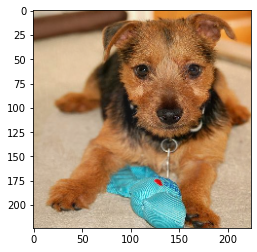

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1 - a) * image_a + a * image_b
    mixed_label = (1 - a) * label_a + a * label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

* 그러면 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현해 본다.

In [17]:
def mixup(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    mixed_imgs   = []
    mixed_labels = []

    for i in range(batch_size):
        image_a                = image[i]
        label_a                = label[i]
        j                      = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b                = image[j]
        label_b                = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs   = tf.reshape(tf.stack(mixed_imgs),   (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### 6.  프로젝트: CutMix 또는 Mixup 비교실험 하기

#### 6_1. Augmentation을 적용한 데이터셋 만들기

In [18]:
def onehot(image, label, prob = 1.0, batch_size = 16, img_size = 224, num_classes = 120):
    imgs   = []
    labels = []

    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))

    onehot_imgs = tf.reshape(tf.stack(imgs),(batch_size, img_size, img_size, 3))
    
    return onehot_imgs, labels

In [19]:
def apply_normalize_on_dataset(ds, is_test = False, batch_size = 16, with_aug = False, with_cutmix = False, with_mixup = False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls = 2)
    
    if not is_test and with_aug:     # basic augmentation
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:  # cutmix
        ds = ds.map(cutmix, num_parallel_calls = 2)
        
    elif not is_test and with_mixup: # mixup
        ds = ds.map(mixup, num_parallel_calls = 2)
        
    else:
        ds = ds.map(onehot, num_parallel_calls = 2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split         = ["train", "test"],
    as_supervised = True,
    shuffle_files = True,
    with_info     = True
)

In [21]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug    = False)
ds_train_aug    = apply_normalize_on_dataset(ds_train, with_aug    = True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix = True)
ds_train_mixup  = apply_normalize_on_dataset(ds_train, with_mixup  = True)
ds_test         = apply_normalize_on_dataset(ds_test,  is_test     = True)

#### 6_2. 모델 만들기

* 프로젝트는 앞서 만들었던 것처럼 비교실험을 위한 모델 두 개를 만들라고 한다.
* 모델은 ResNet-50을 사용한다.
* 하지만 진행하다보면 loss값이 앞에 했던 것과 다르게 설정하는데, basic한 모델과 Cutmix, Mixup을 전부 비교해보고, loss값이 다를 때 basic이 어떻게 변화하는지도 보고 싶어졌다.

In [22]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2020)

In [23]:
resnet50_project = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

In [24]:
aug_resnet50_project = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

In [25]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

In [26]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights     = "imagenet",
        input_shape = (224, 224,3),
        pooling     = "avg"
    ),
    keras.layers.Dense(num_classes, activation = "softmax")
])

#### 6_3. 모델 훈련하기

* 모델을 훈련시킨다.
* 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용한다.
* sparse_categorical_crossentropy()를 사용하지 못하는 이유는 우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문의 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문이다.

In [27]:
resnet50_project.compile(
    loss      = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

aug_resnet50_project.compile(
    loss      = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

cutmix_resnet50.compile(
    loss      = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

mixup_resnet50.compile(
    loss      = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.SGD(lr = 0.01),
    metrics   = ["accuracy"]
)

history_resnet50_project_no_aug = resnet50_project.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

history_resnet50_project_aug = aug_resnet50_project.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch     = int(ds_info.splits["train"].num_examples / 16),
    validation_steps    = int(ds_info.splits["test"].num_examples  / 16),
    epochs              = EPOCH,
    validation_data     = ds_test,
    verbose             = 1,
    use_multiprocessing = True
)

Epoch 1/20
  2/750 [..............................] - ETA: 51s - loss: 5.0679 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0499s vs `on_train_batch_end` time: 0.0872s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2190 - accuracy: 0.4498WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0087s vs `on_test_batch_end` time: 0.0280s). Check your callbacks.


750/750 [==============================] - 111s 148ms/step - loss: 2.2190 - accuracy: 0.4498 - val_loss: 3.5336 - val_accuracy: 0.1823
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 0.7728 - accuracy: 0.7886 - val_loss: 1.1245 - val_accuracy: 0.6685
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 0.2951 - accuracy: 0.9278 - val_loss: 1.0710 - val_accuracy: 0.6920
Epoch 4/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1298 - accuracy: 0.9785 - val_loss: 0.9533 - val_accuracy: 0.7285
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0474 - accuracy: 0.9967 - val_loss: 0.9387 - val_accuracy: 0.7365
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0250 - accuracy: 0.9983 - val_loss: 0.9325 - val_accuracy: 0.7378
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0195 - accuracy: 0.9988 - val_loss: 0.9256 - val_accura

750/750 [==============================] - ETA: 0s - loss: 2.2072 - accuracy: 0.4407WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_test_batch_end` time: 0.0288s). Check your callbacks.


750/750 [==============================] - 111s 148ms/step - loss: 2.2072 - accuracy: 0.4407 - val_loss: 2.8288 - val_accuracy: 0.2980
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.9495 - accuracy: 0.7273 - val_loss: 1.3423 - val_accuracy: 0.6159
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.5468 - accuracy: 0.8480 - val_loss: 1.0574 - val_accuracy: 0.6896
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 0.3191 - accuracy: 0.9162 - val_loss: 1.0704 - val_accuracy: 0.6924
Epoch 5/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1735 - accuracy: 0.9613 - val_loss: 1.0258 - val_accuracy: 0.7126
Epoch 6/20
750/750 [==============================] - 112s 149ms/step - loss: 0.1288 - accuracy: 0.9760 - val_loss: 1.0790 - val_accuracy: 0.7125
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 0.0732 - accuracy: 0.9867 - val_loss: 1.0138 - val_accura

750/750 [==============================] - ETA: 0s - loss: 3.8567 - accuracy: 0.2043WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0076s vs `on_test_batch_end` time: 0.0290s). Check your callbacks.


750/750 [==============================] - 112s 149ms/step - loss: 3.8567 - accuracy: 0.2043 - val_loss: 3.7484 - val_accuracy: 0.1521
Epoch 2/20
750/750 [==============================] - 111s 148ms/step - loss: 2.9767 - accuracy: 0.4256 - val_loss: 1.4880 - val_accuracy: 0.5939
Epoch 3/20
750/750 [==============================] - 111s 148ms/step - loss: 2.6787 - accuracy: 0.5197 - val_loss: 1.3608 - val_accuracy: 0.6191
Epoch 4/20
750/750 [==============================] - 111s 148ms/step - loss: 2.4463 - accuracy: 0.5922 - val_loss: 1.2222 - val_accuracy: 0.6606
Epoch 5/20
750/750 [==============================] - 111s 148ms/step - loss: 2.3085 - accuracy: 0.6376 - val_loss: 1.1731 - val_accuracy: 0.6806
Epoch 6/20
750/750 [==============================] - 111s 148ms/step - loss: 2.1638 - accuracy: 0.6879 - val_loss: 1.3043 - val_accuracy: 0.6558
Epoch 7/20
750/750 [==============================] - 111s 148ms/step - loss: 2.0698 - accuracy: 0.7154 - val_loss: 1.3680 - val_accura

750/750 [==============================] - ETA: 0s - loss: 3.7206 - accuracy: 0.2390WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_test_batch_end` time: 0.0295s). Check your callbacks.


750/750 [==============================] - 113s 150ms/step - loss: 3.7206 - accuracy: 0.2390 - val_loss: 4.6355 - val_accuracy: 0.0975
Epoch 2/20
750/750 [==============================] - 112s 149ms/step - loss: 2.8943 - accuracy: 0.4722 - val_loss: 1.6920 - val_accuracy: 0.5276
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.6179 - accuracy: 0.5685 - val_loss: 1.3978 - val_accuracy: 0.6185
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 2.4265 - accuracy: 0.6478 - val_loss: 1.2873 - val_accuracy: 0.6542
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2966 - accuracy: 0.6989 - val_loss: 1.4578 - val_accuracy: 0.6132
Epoch 6/20
750/750 [==============================] - 114s 152ms/step - loss: 2.1680 - accuracy: 0.7404 - val_loss: 1.4536 - val_accuracy: 0.6108
Epoch 7/20
750/750 [==============================] - 115s 153ms/step - loss: 2.0929 - accuracy: 0.7702 - val_loss: 1.2966 - val_accura

#### 6_4. 훈련 과정 시각화하기

* 훈련 과정의 히스토리를 그래프로 시각화한다.

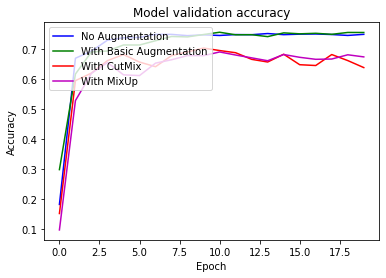

In [28]:
plt.plot(history_resnet50_project_no_aug.history["val_accuracy"], "b")
plt.plot(history_resnet50_project_aug.history["val_accuracy"],    "g")
plt.plot(history_cutmix_resnet50.history["val_accuracy"],         "r")
plt.plot(history_mixup_resnet50.history["val_accuracy"],          "m")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["No Augmentation", "With Basic Augmentation", "With CutMix", "With MixUp"], loc = "upper left")
plt.show()

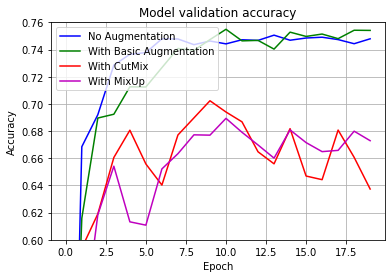

In [30]:
# 조금 더 확대했다.
plt.plot(history_resnet50_project_no_aug.history["val_accuracy"], "b")
plt.plot(history_resnet50_project_aug.history["val_accuracy"],    "g")
plt.plot(history_cutmix_resnet50.history["val_accuracy"],         "r")
plt.plot(history_mixup_resnet50.history["val_accuracy"],          "m")
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["No Augmentation", "With Basic Augmentation", "With CutMix", "With MixUp"], loc = "upper left")
plt.grid(True)
plt.ylim(0.60, 0.76)    # 출력하고자 하는  Accuracy 범위를 지정한다. EPOCH = 20으로 진행시 적절한 범위는 옆에 나온 숫자이다.  
plt.show()

#### 6_5. Augmentation에 의한 모델 성능 비교

* No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석하자.

In [ ]:
# "No Augmentation", "Basic Augmentation", "CutMix", "MixUp" 4가지를 비교해보면 augmentation을 하지 않은 데이터와, 기본적인 augmetation을 한 데이터를 이용한 모델이 성능이 더 좋게나왔다.
# "CutMix", "MixUp"을 적용한 데이터를 이용한 모델의 성능이 더 좋을 것이라고 예상했는데, 둘 다 낮은 성능을 보였다.

### 회고록

In [ ]:
# 노드에서 보여준 apply_normalize_on_dataset 함수를 그대로 썻더니 onehot이 정의되지 않았다는 오류 메세지가 나왔고, cutmix와 mixup을 설정할 수 있는게 제대로 구현되지 않아보였다.
# 그래서 노드의 코드를 기반으로 코드를 바꾸고, onehot 함수를 만들어야 한다고 생각해서 한참을 고민했었다.
# 그리고 모델을 돌렸는데, cutmmix의 함수에서 return값을 mixed_labels로 해야하는데 mixed_label로 해서 데이터 형태가 이상해서 오류가 떳는데..이 오타를 찾는데 또 한참 걸렸다.
# 그렇게 짜서 결과를 봤는데 cutmix와 mixup을 한 모델 두 개가 더 성능이 안 좋게 나온듯 해서 내가 문제인지...원래 그런건지 모르겠다.